# 24新卒データベース研修: SQL演習

Google Colaboratory（通称Colab）を利用すると Python のスクリプトを対話的に実行した結果をNotebookという形式でまとめることができます。ここではGoogleのBigQueryというサービスを利用してSQLの使い方を学んでいきます。

```
【注意】新型コロナウイルスに関係するオープンデータを取り扱っています。
新型コロナウイルスについては、必ず1次情報として厚生労働省や首相官邸のウェブサイトなど公的機関で発表されている情報をご確認ください。
```

## 目次

1. 設定
2. データの取得
3. データの操作
4. 集計
1. 条件式
5. 集合操作
6. インデックス
7. 【応用】分析関数（ウィンドウ関数）
1. 片付け

## 設定

### Google Colabで演習をはじめる方法

1. Google Colab ( https://colab.research.google.com/ ) を開く
2. 「Open notebook」ウィンドウの中から「GitHub」タブを選択
3. 「Enter a GitHub URL or search by organization or user」テキストボックスに演習用GitHubリポジトリのURLを入力する
    - `https://github.com/mixigroup/2024BeginnerTrainingDataBaseAnalysisPublic`
4. SQL演習用ノートブック `24db_sql.ipynb` を選択して開く

### Google Cloud SDK設定

最初にBigQueryを利用するための環境を構築していきます。まずはGoogleアカウントのOAuthトークンを取得しノートブック上でGoogle Cloud SDKを利用できるようにします。

認証の流れ

- 下記のスクリプトを実行する（Shift + Enter）
- 表示されるURLをブラウザで開きColaboratoryによるアクセスを許可
- 英数字と記号からなるトークン文字列をコピー
- URLの下に入力されている入力ボックスにトークン文字列をペーストしてEnter

まずは下記のセルを実行してみましょう。
セルのコードを実行するには、セルをクリックして選択し、コードの左側にある実行ボタンをクリックするか、キーボード ショートカット「command+return」または「Ctrl+Enter」を使用します。



In [ ]:
#
# OAuth認証
#
from google.colab import auth
auth.authenticate_user()

`!`（びっくりマーク）で始まる行はシェルコマンドとして取り扱われます。

gcloud コマンドを使って認証情報が設定できたか確認していきます。

In [ ]:
# このセルの実行結果に自分のメールアドレスが表示されたら準備完了です
! gcloud auth list

Google Cloud SDKの設定を確認できたら安全のためブラウザのトークンが表示されているタブを閉じておきましょう。

### 演習用のGoogle Cloudプロジェクト作成

Google Cloudに限らずクラウドサービスでは無料枠が提供されていることがあります。クラウドサービスのコスト感を掴むには実際に触ってみるのが手っ取り早いです。基本的にはクラウドサービス側の思惑で料金が決まっているので触ってみると思っているより安かったり高かったりすることがあります。

BigQueryの場合、サンドボックスというオプションが無料枠に相当します。これを利用するための演習用のGoogle Cloudプロジェクトを作成してみましょう。

ここで作成するGCPプロジェクトのIDは下記のセルを実行することで取得できます。

In [ ]:
import uuid
PROJECT_ID=f'db-training-{str(uuid.uuid4())[:8]}'

PROJECT_ID

下記のセルを実行すると、GCPプロジェクトを作成できます。  
波括弧で囲まれた文字列はPythonの式として評価されるため、`{PROJECT_ID}` には上記で取得したプロジェクトIDが入ります。

In [ ]:
! gcloud projects create {PROJECT_ID}

上記のセルを実行してもうまく行かない場合は https://console.cloud.google.com/ で利用規約 (Terms of Service) に同意した上で、もう一度実行してみてください。

下記のスクリプトで出力されるURLを開くとBigQueryのWebコンソール画面に入ることができます。

In [ ]:
print(f'https://console.cloud.google.com/bigquery?project={PROJECT_ID}')

### BigQueryを使ってみる

ここで `%%` で始まる文字列はセルマジックと呼ばれる機能で、セルに対して拡張機能を適用するときに使用します。ここでは BigQuery との連携機能を使用しており `%%bigquery` という文字列の下にあるSQLクエリを BigQuery 上で実行することができます。

In [ ]:
import google.cloud.bigquery.magics
google.cloud.bigquery.magics.context.project = PROJECT_ID

上記のセルを実行すると、 `%%bigquery` で使用するGCPプロジェクトとして前節で作成したプロジェクトを指定できます。  
なお、本演習では使用していませんが、 `%%bigquery --project {PROJECT_ID}` のように `%%bigquery` の引数として使用するGCPプロジェクトを指定する方法もあります。

In [ ]:
%%bigquery
select 'Hello' as World

上記のSQLを実行し下の画像のような結果が表示されたらBigQueryの設定完了です 👌

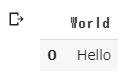

### Colab TIPS: ツールバーにコーギーや猫を表示するには 🐶🐱

[ツール] => [設定] => [その他] で [コーギーモード] ( [猫モード] ) を有効化すると、ツールバー上でコーギー (猫) が走ります。

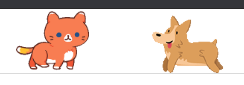

## データの取得

BigQueryでは公開データセットが提供されています。まずは公開データセットにどのようなデータが入っているかの調査を通してSELECT文の使い方を学んでみましょう。

BigQueryではINFORMATION_SCHEMAというテーブル情報を取得するためのメタデータが提供されているので、こちらのメタデータを使ってデータセットの調査を行なっていきます。  
なお、同様のメタデータはMySQLやPostgreSQL等のRDBMSでも提供されています。

こちらではジョンズ・ホプキンス大学が提供する新型コロナウイルス（COVID-19）に関する公開データセットのテーブル情報を参照しています。


### SELECT文: 基本形

SQLクエリを使ってデータを取得する時はSELECT文を利用します。  

```sql
SELECT
    <式>
FROM
    <テーブル名>
;
```

BigQueryのおいては `<テーブル名>` としては以下のようなフォーマットで記述できます。  
ref. https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#select_list

```sql
SELECT * FROM TableName;
SELECT * FROM DatasetName.TableName;
SELECT * FROM ProjectID.DatasetName.TableName;
```

名前に記号が含まれている場合はエスケープ処理が必要な場合もあります。
Google SQLにおけるエスケープはバッククォート ( `` ` `` )を利用します。

```sql
SELECT * FROM `bigquery-public-data`.`covid19_jhu_csse`.`INFORMATION_SCHEMA.TABLES`;
SELECT * FROM `bigquery-public-data.covid19_jhu_csse.INFORMATION_SCHEMA.TABLES`;
```

上記のクエリでは、先ほど紹介したジョンズ・ホプキンス大学が提供する新型コロナウイルス（COVID-19）に関する公開データセットのテーブル情報を取得しています。

- Project ID: `bigquery-public-data`
- Dataset Name: `covid19_jhu_csse`
- Table Name: `INFORMATION_SCHEMA.TABLES`

※ BigQueryにおける [`INFORMATION_SCHEMA`](https://cloud.google.com/bigquery/docs/information-schema-intro) ビューは、BigQueryオブジェクトに関するメタデータ情報を提供するシステム定義の読み取り専用ビューです。  テーブル名の一覧やカラムのdescriptionなどをSQLで取得したい場合に便利な情報を提供してくれます。

In [ ]:
%%bigquery
-- これはコメントです
# これもコメントです
/* これまたコメントです */

select
  # 全てのカラムを取ってくる
  *
from
  `bigquery-public-data.covid19_jhu_csse.INFORMATION_SCHEMA.TABLES`
;

公開データセットに含まれるテーブルの名称や作成時刻が確認できました。

### LIMIT句

`LIMIT`句を利用することで取得するレコード数を制限することができます。  

MySQLをはじめとするOLTP用途のデータベースにおいては大量のデータを制限なしに取得するとデータベースのクライアントに負荷がかかりトラブルの原因になります。

Google BigQueryをはじめとするOLAP用途のデータベースではLIMIT句によって表示するレコードの量を制限することはできますが、クエリの種類によってはスキャンするデータの量は制限できないことがあります。

ただし集計処理せずにそのまま生データを見る際には基本的にはLIMIT句をつけた方が無駄な処理が走らずに済むため、`SELECT` 文を使ってデータを見るときは`LIMIT`句で取得するレコード数を制限する習慣を付けると良いでしょう。

問1. `LIMIT`句を使って `bigquery-public-data.covid19_jhu_csse.confirmed_cases` というテーブルに含まれるレコードを10件表示してみましょう。

In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
limit 10

### ORDER BY句
取得するレコードの順番を並び替える際は`ORDER BY`句を使います。

`ORDER BY`で指定したカラム名の後に`ASC`を付与すると昇順、`DESC`を付与すると降順でソートされます。  
何もつけなかった場合は昇順になります。

問2. `bigquery-public-data.covid19_jhu_csse.confirmed_cases` を、`country_or_region` 列で昇順・降順で並び替えて10件表示してみましょう。

In [ ]:
%%bigquery


In [ ]:
#@title 解答(昇順)その1 {display-mode: "form"}
%%bigquery
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
order by
  country_or_region asc
limit 10

In [ ]:
#@title 解答(昇順)その2 {display-mode: "form"}
%%bigquery
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
order by
  country_or_region # ascがデフォルトなので省略できます
limit 10

In [ ]:
#@title 解答(降順) {display-mode: "form"}
%%bigquery
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
order by
  country_or_region desc
limit 10

### WHERE句

WHERE句に検索条件を指定すると取得対象のレコードを絞り込むことができます。

先ほどのクエリの結果をみると `country_or_region` というカラムに国名が入っていることがわかります。

問3. WHERE句を使って日本（`Japan`）のレコードを取得してみましょう。



In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
where
  country_or_region = 'Japan'
limit 10

日本の感染者数に関するデータが取得できました。国名を表すカラムのほかに位置情報に関する情報も入っており、`_1_22_20` などのカラムは `_MM_DD_YY` 形式である日付における感染者数を表しているようです。

## 集計処理

### COUNT関数

`tmp` スキーマを作成します。BigQueryではCREATE SCHEMA文を使うとスキーマ (データセット) を作成できます。

In [ ]:
%%bigquery
create schema tmp;

BigQueryの公開データセットからデータを取得し `tmp` スキーマの `confirmed_cases` というテーブルにデータを格納します。

多くのクエリエンジンにはテーブルを作成する際に SELECT 文の実行結果をそのまま利用できる `CREATE TABLE AS`（CTAS） と呼ばれる構文が用意されています。

データを整形する過程で必要な一時データを格納したいときや、異なるデータベースサーバーに入っているテーブルデータをコピーするときなどに便利な機能です。

In [ ]:
%%bigquery
create table tmp.confirmed_cases as
select
  *
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases

COUNT関数を利用するとレコード数を数えることができます。

問1. 先ほど作成したテーブルにデータが欠損なく入っているかを確認するため、公開データセットと先ほど作成したテーブルのレコード数を比較してみましょう。

In [ ]:
%%bigquery


In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  count(1) as num
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases

In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  count(1) as num
from
  tmp.confirmed_cases

公開データセットのレコード数と先ほど作成したテーブルのレコード数が一致していれば、欠損はなさそうです。

### 集約操作（GROUP BY句）

データセットを見ていると国によっては複数のレコードを持っていることが分かります。GROUP BY 句を利用すると指定したカラムの値でグループ分けした結果に対して COUNT 関数などを利用した集計を行うことができます。

```sql
SELECT
  <カラム>
FROM
  <テーブル>
WHERE
  <条件>
-- NEW!!
GROUP BY
  <集約するカラム> -- 複数指定可能
HAVING
  <集約後の結果に対する条件>
```

#### BigQuery => Pandas

公開データセットでは各レコードに国・州ごとの感染者数が入っています。

|国名|州名|日付1|日付2|...|
|:--:|:--:|--:|--:|--:|
|国A|州1|123|456|...|
|国A|州2|234|567|...|
|国B||789|999|...|

しかし、日ごとの推移を見る場合、各レコードに国・州・日付ごとの感染者数が入っている形式の方が扱いやすいです。

|国名|州名|日付|感染者数|
|:--:|:--:|:--:|--:|
|国A|州1|日付1|123|
|国A|州1|日付2|456|
|国A|州1|...|...|
|国A|州2|日付1|234|
|国A|州2|日付2|567|
|国A|州2|...|...|
|国B||日付1|789|
|国B||日付2|999|
|国B||...|...|

こちらの操作をSQLで行うことは可能ですが、プログラミング言語で行った方が簡単にできます。ここでは Pandas という Python のデータ操作用フレームワークを利用して行ってみましょう。

"pandas - Python Data Analysis Library"
https://pandas.pydata.org/

複数の州を持つ国の confirmed_cases の和を国・日別に取ってみましょう。

`%%bigquery` マジックでは引数に変数名を指定すると、クエリの実行結果を Pandas の DataFrame として格納してくれます。  
また、BigQueryでは`except`を使うことで、指定したカラム以外の全カラムを取得することができます。

In [ ]:
%%bigquery df_provinces
select
  -- 地理データ以外の全カラムを取得
  * except (latitude, longitude, location_geom)
from
  tmp.confirmed_cases
where
  province_or_state is not null

headメソッドを使って上位のレコードを表示してみます。

In [ ]:
df_provinces.head()

Pandasを使って国・州・日付ごとに感染者数が入っているテーブルを作成します。

"pandasでstack, unstack, pivotを使ってデータを整形 | note.nkmk.me"
https://note.nkmk.me/python-pandas-stack-unstack-pivot/

In [ ]:
import pandas as pd
import datetime

df_pivot_stack = pd.pivot_table(df_provinces, index=['country_or_region', 'province_or_state']).stack().reset_index()
df_pivot_stack.columns = ['country_or_region', 'province_or_state', 'date', 'confirmed_cases']
df_pivot_stack.date = df_pivot_stack.date.map(lambda d: datetime.datetime.strptime(d, '_%m_%d_%y'))
df_pivot_stack

#### Pandas => BigQuery

[pandas_gbq](https://pandas-gbq.readthedocs.io/en/latest/)を利用することでデータフレームをBigQueryのテーブルに格納することができます。

In [ ]:
import pandas_gbq

table_schema = [
    {'name': 'country_or_region', 'type': 'string'},
    {'name': 'province_or_state', 'type': 'string'},
    {'name': 'date', 'type': 'date'},
    {'name': 'confirmed_cases', 'type': 'float64'}
]

pandas_gbq.to_gbq(df_pivot_stack.astype({'country_or_region': str, 'province_or_state': str, 'confirmed_cases': float}), 'tmp.pivot_stack', PROJECT_ID, table_schema=table_schema)

複数州を持つ国についても日別の推移を縦持ちで取れるようになりました。

In [ ]:
%%bigquery
select
  *
from
  tmp.pivot_stack
limit 10

問2. GROUP BY 句を使って国・日別で`confirmed_cases`の合計を集計してみましょう。

ヒント:
*   `tmp.pivot_stack` テーブルを使います。
*   和の集計には `SUM` 関数を使います。
*   `tmp.pivot_stack` テーブルは州ごと・日別の感染者数になっているのでこれを国・日別に集約するイメージです

In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  country_or_region,
  date,
  sum(confirmed_cases) as confirmed_cases_sum
from
  tmp.pivot_stack
group by
  country_or_region,
  date

order by
  country_or_region,
  date

limit 10

### おまけ BigQueryにおけるPivot/Unpivot

Google BigQueryにおいては2021年7月19日のアップデートでgenerally available（GA）となったPIVOT/UNPIVOT演算子を利用すれば比較的簡単にPivot/Unpivot処理をできるようになりました。  

1. https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#pivot_operator
2. https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#unpivot_operator

```sql
SELECT * FROM Produce

/*---------+----+----+----+----*
 | product | Q1 | Q2 | Q3 | Q4 |
 +---------+----+----+----+----+
 | Kale    | 51 | 23 | 45 | 3  |
 | Apple   | 77 | 0  | 25 | 2  |
 *---------+----+----+----+----*/

SELECT * FROM Produce
UNPIVOT(sales FOR quarter IN (Q1, Q2, Q3, Q4))

/*---------+-------+---------*
 | product | sales | quarter |
 +---------+-------+---------+
 | Kale    | 51    | Q1      |
 | Kale    | 23    | Q2      |
 | Kale    | 45    | Q3      |
 | Kale    | 3     | Q4      |
 | Apple   | 77    | Q1      |
 | Apple   | 0     | Q2      |
 | Apple   | 25    | Q3      |
 | Apple   | 2     | Q4      |
 *---------+-------+---------*/
```

Pivot/Unpivotしたい列を列挙すればいい感じにPivot/Unpivotしてくれる便利な演算子ですが、今回Unpivotしたい列数は1000を超えるためそれらを列挙するのは骨が折れます。  

BigQueryにおいては手続き言語としてSQLを利用する手段が用意されており、これを使えば動的に生成した文字列としてのSQLを実行できるのでなんとかできそうです。  

1. https://cloud.google.com/bigquery/docs/reference/standard-sql/procedural-language

```sql
# 変数の宣言
DECLARE date_columns ARRAY<STRING>;

# 代入
SET date_columns = ARRAY(
  SELECT DISTINCT column_name
  FROM tmp.INFORMATION_SCHEMA.COLUMNS
  WHERE table_name = 'confirmed_cases' AND REGEXP_CONTAINS(column_name, r'\_\d{1,2}\_\d{1,2}\_\d{1,2}')
);

# 動的に生成した文字列を実行
# 信頼できるソースのみを入力とすること！（SQL injectionが可能）
EXECUTE IMMEDIATE
  'CREATE OR REPLACE TABLE tmp.pivot_stack AS '||
  'SELECT province_or_state,country_or_region,'||
    'DATE(REGEXP_REPLACE(date, r"\\_(\\d{1,2})\\_(\\d{1,2})\\_(\\d{1,2})", "20\\\\3-\\\\1-\\\\2")) date,'||
    'CAST(confirmed_cases AS FLOAT64) confirmed_cases '||
  'FROM tmp.confirmed_cases UNPIVOT(confirmed_cases FOR date IN ('||
    ARRAY_TO_STRING(date_columns, ',')||
  ')) WHERE province_or_state IS NOT NULL';
  ```

## 条件式

### CASE式
CASE式は条件分岐に相当するもので、2通りの書き方があります。

```sql
-- 単純CASE式
CASE <カラム>
    WHEN <値> THEN <カラム = 値のときの返り値>
    ELSE <上記を満たさないときの返り値>
END
```

```sql
-- 検索CASE式
CASE
    WHEN <条件> THEN <条件を満たすときの返り値>
    ELSE <上記を満たさないときの返り値>
END
```


前章では複数の州を持つ国のconfirmed_casesの推移を国・日別で見ましたが、これを大州別・日別で見てみましょう。

国と大州の対応関係は次のようになっています。

|国|大州|
|:--:|:--:|
|`Canada`|`America`|
|`United Kingdom`|`Europe`|
|`France`|`Europe`|
|`Netherlands`|`Europe`|
|`Denmark`|`Europe`|
|`China`|`Asia`|
|`Australia`|`Australia`|

問1. 上記の国と大州の表を参考に国名を大州名に変換し、大州・日別のconfirmed_casesの合計を集計してみましょう。

結果のイメージ

|日付|大州|confirmed_cases|
|---|---|---|
|2021-01-01|America|1234|
|2021-01-01|Europe|2345|
|2021-01-01|Asia|3456|
|2021-01-01|Australia|4567|
|2022-01-02|America|1000|


ヒント:
  CASE文を用いて、国名を大州名に変換するとよい

In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  case country_or_region
    when 'Canada' then 'America'
    when 'United Kingdom' then 'Europe'
    when 'France' then 'Europe'
    when 'Netherlands'then 'Europe'
    when 'Denmark' then 'Europe'
    when 'China' then 'Asia'
    else country_or_region
  end as region,
  date,
  sum(confirmed_cases) as confirmed_cases_sum
from
  tmp.pivot_stack
group by
  region,
  date

order by
  date,
  region

limit 20

上記のクエリは以下のように書くこともできます。

In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  case
    when country_or_region = 'Canada' then 'America'
    when country_or_region IN ('United Kingdom', 'France', 'Netherlands', 'Denmark') then 'Europe'
    when country_or_region = 'China' then 'Asia'
    else country_or_region
  end as region,
  date,
  sum(confirmed_cases) as confirmed_cases_sum
from
  tmp.pivot_stack
group by
  region,
  date

order by
  date,
  region

limit 20

## 集合操作(サブクエリ・UNION)

ここから少し複雑なSELECT文を扱っていきます。

### サブクエリ

SELECTの結果を別のクエリ内で使用することをサブクエリと言います。


問1. 全世界の`confirmed_cases`のうち、カナダの`confirmed_cases`の割合を日別に集計することを考えます。

 (1) 日毎の全世界の`confirmed_cases`とカナダの`confirmed_cases`の合計をそれぞれ集計してみましょう。


 出力例

 |date|カナダの件数|全世界の件数|
 |---|---|---|
 |2020-09-01| 300| 10000|
 |2020-09-02| 250| 12000|



In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery

select
  date,

  -- where句でカナダのみに絞り込むと confirmed_cases_sum_all の集計がうまくいかないので、CASE式で絞り込んでいる
  sum(case when country_or_region = 'Canada' then confirmed_cases end) as confirmed_cases_sum_canada,

  sum(confirmed_cases) as confirmed_cases_sum_all
from
  tmp.pivot_stack
group by
  date


limit 10

(2) (1)のクエリをサブクエリとして、全世界の`confirmed_cases`のうち、カナダの`confirmed_cases`の割合を日別に集計してみましょう。

In [ ]:
%%bigquery



In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
select
  date,
  confirmed_cases_sum_canada,
  confirmed_cases_sum_all,
  1.0 *  confirmed_cases_sum_canada / confirmed_cases_sum_all as confirmed_cases_percent_canada
from
(
  select
    date,

    -- where句でカナダのみに絞り込むと confirmed_cases_sum_all の集計がうまくいかないので、CASE式で絞り込んでいる
    sum(case when country_or_region = 'Canada' then confirmed_cases end) as confirmed_cases_sum_canada,

    sum(confirmed_cases) as confirmed_cases_sum_all
  from
    tmp.pivot_stack
  group by
    date
)

order by
  date

limit 10

### WITH句

WITH句を使うとサブクエリに名前を付けてクエリの外側に持っていくことができます。これにより、ネストを下げたりサブクエリを再利用したりすることができます。WITH句で定義したサブクエリは通常のテーブルと同様にクエリすることができます。

RDBMSの世界ですとMySQLは長らくサポートしていませんでしたがバージョン8.0から利用できるようになっています。

```sql
SELECT
  *
FROM (
  SELECT ...
) AS cte

# 上記の文と等価
WITH cte AS (
  SELECT ...
)
SELECT
  *
FROM
  cte

# 複数定義する場合はカンマでつなげる
WITH cte1 AS (...),
  cte2 AS (...)
SELECT...
```

問2. 問1(2) をWITH句を用いて書き直してみましょう。

In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}
%%bigquery
with canada_confirmed_cases as (
  select
    date,

    -- where句でカナダのみに絞り込むと confirmed_cases_sum_all の集計がうまくいかないので、CASE式で絞り込んでいる
    sum(case when country_or_region = 'Canada' then confirmed_cases end) as confirmed_cases_sum_canada,

    sum(confirmed_cases) as confirmed_cases_sum_all
  from
    tmp.pivot_stack
  group by
    date
)

select
  date,
  confirmed_cases_sum_canada,
  confirmed_cases_sum_all,
  1.0 *  confirmed_cases_sum_canada / confirmed_cases_sum_all as confirmed_cases_percent_canada
from canada_confirmed_cases

order by
  date

limit 10

### UNION句

UNION 句を利用するとクエリの結果を縦方向に結合することができます。

公開データセットのテーブル情報を見ると、 `confirmed_cases` / `recovered_cases` / `deaths` の3テーブルがあることがわかります。

In [ ]:
%%bigquery
select
  *
from
  bigquery-public-data.covid19_jhu_csse.INFORMATION_SCHEMA.TABLES
limit 10

ここでは日本のデータについて `confirmed_cases` / `recovered_cases` / `deaths` の結果を `UNION` 句で結合してみましょう。

label というカラムに元テーブルの名前を格納することで、どのテーブル由来のデータかを区別できるようにしています。

UNION だけだとそれぞれのセットで重複するものが排除されますがその分パフォーマンスが落ちてしまいます。UNION ALL と指定すると重複チェックを行わずに結果を結合することができます。

In [ ]:
%%bigquery
select
  'confirmed' as label,
  * except (latitude, longitude, location_geom)
from
  bigquery-public-data.covid19_jhu_csse.confirmed_cases
where
  country_or_region = 'Japan'

union all
select
  'recovered' as label,
  * except (latitude, longitude, location_geom)
from
  bigquery-public-data.covid19_jhu_csse.recovered_cases
where
  country_or_region = 'Japan'

union all
select
  'death' as label,
  * except (latitude, longitude, location_geom)
from
  bigquery-public-data.covid19_jhu_csse.deaths
where
  country_or_region = 'Japan'

## 集合操作(JOIN)

JOINを利用することで複数のテーブルまたはサブクエリを特定の条件で横方向に結合することができます。

```sql
    SELECT
      <式>
    FROM
      <テーブル>
      -- NEW!!
      INNER JOIN
        <結合するテーブル> ON <結合条件>
```

結合方式には以下の3種類があり、それぞれ役割が異なります。

- 内部結合（INNER JOIN）
  - 一致するもの
- 外部結合（OUTER JOIN）
  - 一致しないときはNULL
- クロス結合（CROSS JOIN）
  - 直積
  - 配列データをバラしたりするときに便利


### 内部結合 (INNER JOIN)
ゲームを想定したデータでJOINを行ってみましょう。  
まず、ユーザー情報とステージ情報、プレイログ (誰がどのステージをプレイしたか) の3テーブルを作ります。

In [ ]:
%%bigquery

create schema if not exists tmp;

-- ユーザー情報
create or replace table tmp.users (
    user_id int64,
    user_name string
) as
select 1 as user_id, 'Alice' as user_name
union all select 2 as user_id, 'Bob' as user_name
union all select 3 as user_id, 'Charlie' as user_name;

-- ステージ情報
create or replace table tmp.stages (
    stage_id int64,
    stage_name string
) as
select 1 as stage_id, 'Easy Stage' as stage_name
union all select 2 as stage_id, 'Normal Stage' as stage_name;

-- プレイログ (誰がどのステージをプレイしたか)
create or replace table tmp.plays (
    user_id int64,
    stage_id int64,
    played_at timestamp
) as
select
  user_id, stage_id, played_at
from
  unnest([struct<user_id int64, stage_id int64, played_at timestamp>
    (1,1, timestamp('2024-04-15 10:00:00+09:00')),
    (1,2, timestamp('2024-04-15 12:00:00+09:00')),
    (2,1, timestamp('2024-04-15 08:00:00+09:00')),
    (1,1, timestamp('2024-04-15 13:00:00+09:00'))
  ])
;

プレイログを見てみます。

In [ ]:
%%bigquery
select
  *
from
  tmp.plays
limit 10

そのままだと誰がどのステージをプレイしたのか分からないのでユーザー情報とステージ情報をJOINしてみます。

In [ ]:
%%bigquery
select
  user_name,
  stage_name,
  played_at,
from
  tmp.plays
  inner join tmp.users using(user_id)
  inner join tmp.stages using(stage_id)
limit 10

人間にわかりやすい形でプレイログが出てきました。

### 外部結合 (OUTER JOIN)

usersにplaysをLEFT OUTER JOINすると、プレイしていないユーザーもplays由来のカラムがNULLになった状態で出てきます。

In [ ]:
%%bigquery
select
  *
from
  tmp.users
  left outer join tmp.plays using(user_id)
limit 10

`LEFT OUTER JOIN` の考え方ですが、 `LEFT OUTER JOIN` の左にあるテーブル ( `users` ) をベースに右にあるテーブル ( `plays` ) を結合するイメージです。

```sql
from users left outer join plays
```

なお、実際にはほとんど使われませんが、 `RIGHT OUTER JOIN` (右にあるテーブルをベースに左にあるテーブルを結合する) もあるので、知識として知っておくと良いです。

### クロス結合 (CROSS JOIN)

CROSS JOINは配列データをバラすときに便利です。と言っても具体例をみないと分かりづらいのでGoogle SQLのARRAY型を使ってCROSS JOINの使いどころを確認してみましょう。

In [ ]:
%%bigquery
-- ARRAY型を持ったテーブルを作成
create or replace table tmp.guild (
  guild_name string,
  member_ids array<int64>,
) as
select
  'コーギーモード' as guild_name,
  [1,2] as member_ids
union all
select
  'ネコモード' as guild_name,
  [2,3] as member_ids,
;

In [ ]:
%%bigquery
select
  *
from
  tmp.guild
limit 10

配列を1行ずつバラしていくときにCROSS JOINが活用できます。  
[UNNEST](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#unnest_operator)演算子を利用することで配列型のカラムをテーブルのように扱うことができます。

In [ ]:
%%bigquery
-- unnest実演
select
  *
from
  unnest([1,2,3,4,5])

In [ ]:
%%bigquery
select
  guild_name,
  member_id
from tmp.guild
  cross join unnest(member_ids) as member_id

また、Google SQLにおいては[Comma cross join](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#cross_join)という記法により `CROSS JOIN` キーワードは省略することができます。  
配列をバラす`UNNEST`演算子を利用する際は`CROSS JOIN`キーワードを省略して書くことが多い印象です。

In [ ]:
%%bigquery
select
  guild_name,
  member_id
from tmp.guild, unnest(member_ids) as member_id

さらに、`UNNEST` 演算子も構文によっては省略できてしまいます。  
とはいえ、 省略し過ぎてしまうと他人からみてわかりにくくなってしまう可能性があるため特に他人に見せるSQLでの多用は非推奨です。

In [ ]:
%%bigquery
select
  guild_name,
  member_id
from tmp.guild, guild.member_ids as member_id

## 分析関数（ウィンドウ関数）

分析関数はデータの集計だけではなく機械学習用のデータセットを作成するのにも便利に使える機能です。分析関数を利用すると、今見ているレコードだけでなく、他のレコードの状態も見て集計処理を実行できます。

RDBMSの世界ですと、MySQLではWITH句と同様にバージョン8.0からサポートされています。

### LAG / LEAD 関数

あるレコードについて指定の順序で前後にあるレコードのカラムを取得するための機能です。  
LAG関数で前にあるレコードのカラムを、LEAD関数で後ろにあるレコードのカラムを取得できます。  
例えば、日別のログイン履歴からログインした日付と前回ログインした日付の差、すなわちログインしなかった日数を集計するといったことができます。

LAG関数を使って、カナダのブリティッシュコロンビア州における前日の`confirmed_cases`を取得してみます。
ウィンドウ関数の利用時には `GROUP BY` による集約は必要なく、関数の後ろに `OVER` で始まる順序などの条件指定が入ります。
今回の場合ですと、`confirmed_cases`を`date`でソートして、1レコード前の`confirmed_cases`を取得しています。

In [ ]:
%%bigquery
-- カナダのconfirmed_cases推移（日別）
select
  date,
  confirmed_cases,
  lag(confirmed_cases) over (order by date) prev_confirmed_cases
from
  tmp.pivot_stack
where
  country_or_region = 'Canada'
  and province_or_state = 'British Columbia'

order by
  date

問1. 元のデータセットは`confirmed_cases`が累計値になっています。  
前日との差分を取ることで1日あたりどれくらい増加したのか集計してみましょう。

出力例

 |date|confirmed_cases|`前日との差分`|
 |---|---|---|
|2020-03-12|46|7|
|2020-03-13|64|18|
|2020-03-14|64|0|
|2020-03-15|73|9|
|2020-03-16|103|30|
|2020-03-17|103|0|


In [ ]:
%%bigquery
SELECT
  date,
  confirmed_cases - LAG(confirmed_cases) OVER (ORDER BY date) AS confirmed_cases_diff
FROM
  tmp.pivot_stack
WHERE
  country_or_region = 'Canada'
  AND province_or_state = 'British Columbia'
ORDER BY date

In [ ]:
#@title 解答 {display-mode: "form"}

%%bigquery
select
  date,
  confirmed_cases,
  confirmed_cases - lag(confirmed_cases) over (order by date) confirmed_cases_diff
from
  tmp.pivot_stack
where
  country_or_region = 'Canada'
  and province_or_state = 'British Columbia'
order by
  date

### 累積和

先ほどは累計値を日別に変換しましたが、逆に累計値を求めるにはどうすればよいでしょうか。  
SUM関数やCOUNT関数などもウィンドウ関数として利用することができ、あるレコードまでの累積和などを求めることができます。

問2. 問1の結果を利用して累計値を求めてみましょう


In [ ]:
%%bigquery
-- 問1の結果(前日からの増加分)
with df_canada as (
  select
    date,
    # confirmed_cases, # 累積値に頼らない
    confirmed_cases - lag(confirmed_cases) over (order by date) confirmed_cases_diff # 前日からの増加分
  from
    tmp.pivot_stack
  where
    country_or_region = 'Canada'
    and province_or_state = 'British Columbia'
)
-- ここから問2

SELECT
  date,
  SUM(confirmed_cases_diff) OVER (ORDER BY date )
FROM df_canada


In [ ]:
#@title 解答 {display-mode: "form"}

%%bigquery
with df_canada as (
  select
    date,
    confirmed_cases,
    confirmed_cases - lag(confirmed_cases) over (order by date) confirmed_cases_diff
  from
    tmp.pivot_stack
  where
    country_or_region = 'Canada'
    and province_or_state = 'British Columbia'
)

select
  date,
  confirmed_cases,
  sum(confirmed_cases_diff) over (order by date) as confirmed_cases_cumsum,
  confirmed_cases = sum(confirmed_cases_diff) over (order by date) as `自分で求めた結果と一致しているか確認`
from
  df_canada

order by
  date

### RANK / ROW_NUMBER 関数

`RANK` / `ROW_NUMBER` 関数を使うとランキングを求めたり行番号を求めることができます。

同一の値に対し、 `RANK` では同じ番号が振られ、ROW_NUMBERでは最初に見つかった順に番号が振られます。

`ROW_NUMBER`の結果が1になるレコードだけを取ってくれば、レコードの重複を排除できるため、`ROW_NUMBER`はレコードの重複排除でよく利用されます。

ここでは`RANK`を利用して`confirmed_cases`が多い順にランク付けをしてみましょう。

In [ ]:
%%bigquery
select
  province_or_state,
  confirmed_cases,
  rank() over (order by confirmed_cases desc) as rank
from
  tmp.pivot_stack
where
  country_or_region = 'Canada'
  and date = '2020-03-31'

order by
  confirmed_cases desc

問3. 上位三件に絞り込んでみましょう

ヒント: SELECT句/FROM句/WHERE句/HAVING句それぞれが実行される順序は以下のようになっています

1. FROM句
2. WHERE句
3. SELECT句
4. HAVING句

SELECT句で集計処理したSUM関数の結果などをWHERE句で絞り込みに使えない理由は上記の実行順序が理由です。  
（同様にSELECT句でASによって列エイリアスした列名をWHERE句で参照できないのもこれが理由です）

```sql
select num as numnum
from (select 1 as num)
where numnum > 1 // Error! Unrecognized name: numnum
```



In [ ]:
%%bigquery


In [ ]:
#@title 解答 {display-mode: "form"}


%%bigquery
select
  *
from
  (select
    province_or_state,
    confirmed_cases,
    rank() over (order by confirmed_cases desc) as rank
  from
    tmp.pivot_stack
  where
    country_or_region = 'Canada'
    and date = '2020-03-31'
  )
where
  rank <= 3

order by
  rank

In [ ]:
#@title 解答その2 {display-mode: "form"}

%%bigquery
select
  province_or_state,
  confirmed_cases,
  rank() over (order by confirmed_cases desc) as rank
from
  tmp.pivot_stack
where
  country_or_region = 'Canada'
  and date = '2020-03-31'
# 上位3件に絞り込むだけならorder byとlimitの組み合わせでも実現できます
# 一般に分析関数の結果をフィルタリングの条件に利用したい場合は前述の解答のようにサブクエリを一度経由する必要があります
order by rank
limit 3

### おまけ: 分析関数の利用を楽にするQUALIFY句

問3では分析関数の結果をフィルタリングする必要がありました。

```sql
select
  *
from
  (select
    province_or_state,
    confirmed_cases,
    rank() over (order by confirmed_cases desc) as rank
  from
    tmp.pivot_stack
  where
    country_or_region = 'Canada'
    and date = '2020-03-31'
  )
where
  rank <= 3
```

Google SQLでは[QUALIFY句](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#qualify_clause)を利用することでサブクエリを利用しなくても分析関数の結果をフィルタリングすることができます。

```sql
select
  province_or_state,
  confirmed_cases,
  rank() over (order by confirmed_cases desc) as rank
from
  tmp.pivot_stack
where
  country_or_region = 'Canada'
  and date = '2020-03-31'
qualify -- NEW
  rank <= 3
```

分析関数の結果をフィルタリングのみに利用したいならselect句ではなくqualify句で分析関数を呼び出すことでよりスッキリとしたクエリが書けそうですね :+1:

```sql
select
  province_or_state,
  confirmed_cases,
from
  tmp.pivot_stack
where
  country_or_region = 'Canada'
  and date = '2020-03-31'
qualify -- NEW
  rank() over (order by confirmed_cases desc) <= 3
```

### 付録: BigQueryにおける大規模データの取り扱いについて

テラバイト級以上のデータを取り扱う際は全てのデータ（レコード）が集計対象ではないことはしばしばあります。  
（2020年以降のデータを対象として集計したいなど）

BigQueryにおいては[パーティショニング](https://cloud.google.com/bigquery/docs/partitioned-tables?hl=ja)を利用することで課金対象となるデータスキャン量を減らし、クエリのパフォーマンスを改善させることができます。

パーティショニングはあるカラムの値をキーとして物理的に異なる場所へレコードを振り分けることにより、そのカラムでフィルタリングしたときにスキャン対象となるレコードを制限させることができます。（シャーディングに近いですがテーブル自体が複数できるわけではありません）

先ほど作成した `tmp.pivot_stack` テーブルを使ってパーティショニングの効果を確認してみましょう。  
注）サンドボックス環境ではパーティショニングを有効化したデータ入テーブルを作成できなかったのであらかじめセルの実行結果表示させています。

In [ ]:
%%bigquery
-- まずはtmp.pivot_stackのテーブルデータをおさらいします。
select
  min(date) min_date,
  max(date) max_date,
  count(distinct date) count_date,
  count(distinct country_or_region) uniq_country_or_region,
  count(distinct province_or_state) uniq_province_or_state,
from tmp.pivot_stack

Query is running:   0%|          |

Downloading:   0%|          |

,min_date,max_date,count_date,uniq_country_or_region,uniq_province_or_state
0,2020-01-22,2023-03-09,1143,8,91


dateカラムでパーティショニングすることで時系列分析を行う際のデータスキャン量（≠パフォーマンス）を減らすことができそうです。

まずはパーティショニングを有効化したテーブルを作成してみましょう


In [ ]:
%%bigquery

create or replace table tmp.pivot_stack_partitioned
partition by date -- パーティショニングに利用するカラムをpartition byで指定.
as
select * from tmp.pivot_stack;

Query is running:   0%|          |

""


さっそくパーティショニングした場合としていない場合のクエリのパフォーマンスを見てみます。

2023年以降で観測された感染者数が最小だった地域を出力してみるクエリです。


In [ ]:
%%bigquery
-- パーティショニングなし
select date, confirmed_cases, country_or_region, province_or_state
from tmp.pivot_stack as ps
where date >= '2023-01-01'
  and confirmed_cases > 0
qualify
  row_number() over(order by confirmed_cases) = 1

Query is running:   0%|          |

Downloading:   0%|          |

,date,confirmed_cases,country_or_region,province_or_state
0,2023-01-29,4.0,United Kingdom,Pitcairn Islands


In [ ]:
%%bigquery
-- パーティショニングあり
select date, confirmed_cases, country_or_region, province_or_state
from tmp.pivot_stack_partitioned as psp
where date >= '2023-01-01'
  and confirmed_cases > 0
qualify
  row_number() over(order by confirmed_cases) = 1

Query is running:   0%|          |

Downloading:   0%|          |

,date,confirmed_cases,country_or_region,province_or_state
0,2023-03-09,4.0,United Kingdom,Pitcairn Islands


`INFORMATION_SCHEMA.JOBS_BY_USER` テーブルを利用することでこれまでユーザーが発行したクエリジョブの履歴と統計情報を参照できます。

（BigQueryのWebUIにおいては画面下にあるJob Historyからも同様の情報を参照できます）

In [ ]:
%%bigquery
select
  creation_time,
  query,
  total_bytes_processed,
  total_slot_ms,
  cache_hit
from region-us.INFORMATION_SCHEMA.JOBS_BY_USER
where query like '%from tmp.pivot_stack as ps%'
order by creation_time desc
limit 1

Query is running:   0%|          |

Downloading:   0%|          |

,creation_time,query,total_bytes_processed,total_slot_ms,cache_hit
0,2024-04-18 10:47:34.491000+00:00,"-- パーティショニングなし\nselect date, confirmed_cases, ...",4030218,266,False


In [ ]:
%%bigquery
select
  creation_time,
  query,
  total_bytes_processed,
  total_slot_ms,
  cache_hit
from region-us.INFORMATION_SCHEMA.JOBS_BY_USER
where query like '%from tmp.pivot_stack_partitioned as psp%'
order by creation_time desc
limit 1

Query is running:   0%|          |

Downloading:   0%|          |

,creation_time,query,total_bytes_processed,total_slot_ms,cache_hit
0,2024-04-18 10:47:48.046000+00:00,"-- パーティショニングあり\nselect date, confirmed_cases, ...",239768,5559,False


パーティショニングなしのテーブルに対するクエリでは4030218bytes（約4MB)スキャンしていたのに対して、パーティショニングありのテーブルに対するクエリでは約16分の1である239768	（約0.2MB）のスキャンに抑えることができました。

```
4030218.0 / 239768.0
=> 16.808823529411764
```

この16分の1という削減できたデータスキャンサイズの割合は今回のテーブルにおける全体のレコード数に占める2023年以降のレコード数の割合と一致しています。

In [ ]:
%%bigquery
select
  count(*) record_num,
  count(case when date >= '2023-01-01' then 1 end) record_num_2023,
  count(*) / count(case when date >= '2023-01-01' then 1 end)
from
  tmp.pivot_stack

Query is running:   0%|          |

Downloading:   0%|          |

,record_num,record_num_2023,f0_
0,104013,6188,16.808824


パーティショニングをうまく使うことでデータのスキャンサイズを削減できることがわかりました。  
On-demand pricingを課金体系として設定している場合、データのスキャンサイズ削減がそのままコンピューティング料金のコスト削減につながるので、テーブルのアクセスパターン・ユースケースに応じてうまくパーティショニングを活用しましょう :+1:

（ちなみにパーティショニング有りのテーブルでは逆にSlot消費量が増えていることにお気づきでしょうか。  
今回のユースケースではデータのスキャンサイズを削減することには成功しましたが同じデータを処理するために必要なvCPUは多くなったしまったようです。
パーティショニングを設定する際は何を目的としてどのようなアクセスパターンを効率化させたいかを考えたうえでパーティショニング採用の有無、パーティショニングに利用するカラムを考えると良いかもしれません）


## 片付け

演習が終わったら片付けをしましょう。  

```
Do you want to continue (Y/n)?
```

見えづらいですが上記アウトプットの横にテキストボックスが存在するので、`Y` を入力してエンターキーを押すことで削除が可能です。  
以下のようなメッセージが出力されたら削除完了です。

```
Deleted [https://cloudresourcemanager.googleapis.com/v1/projects/<your_deleted_project_id>].

You can undo this operation for a limited period by running the command below.
    $ gcloud projects undelete <your_deleted_project_id>

See https://cloud.google.com/resource-manager/docs/creating-managing-projects for information on shutting down projects.
```

再び演習を行いたい場合は `設定` を行って新たなGCPプロジェクトを作成してください。

### GCPプロジェクトの削除

In [ ]:
! echo PROJECT_ID: {PROJECT_ID}
! gcloud projects delete {PROJECT_ID}